(C) 2023, Gerold Baier, University College London

曾子睿 智能213 U202140980

# Data Analysis Report

Modify the below code for data file "Pat1_Sz01_Onset_1_100Hz.csv" and answer the questions. 

## Import and Functions

In [41]:
import numpy as np
from numpy import pi, linspace, sin, diff, arange, asarray, ndarray, zeros, exp, array, linspace, median, gradient, around
from numpy import triu, triu_indices, triu_indices_from, var, mean, std, sqrt, where, isnan, nan_to_num, delete, floor
from numpy import nan, flip, argwhere, ones, diag, correlate, corrcoef, transpose, cov, flip, ceil, cos, sin, arctan
from numpy import angle, exp, amax, amin, absolute, meshgrid, fill_diagonal, concatenate, c_, real, argsort, tile
from numpy import empty_like, zeros_like, log, logical_and, copy, greater, invert, nonzero, count_nonzero, divide, repeat
from numpy import sign, append, hstack, savetxt, loadtxt, histogram

from numpy.random import normal, permutation
from numpy.linalg import norm

from matplotlib.pyplot import subplots, xlabel, ylabel, hist, bar, legend, axis, axes
from matplotlib.pyplot import figure, xticks, yticks, rcParams, show

from scipy.optimize import curve_fit
from scipy.signal   import butter, sosfilt, find_peaks
from scipy.stats    import spearmanr, entropy
from scipy.spatial  import distance
from scipy.cluster  import hierarchy
from scipy.interpolate import interp1d
from scipy.fft import rfft, rfftfreq

from sklearn.preprocessing import MinMaxScaler

from pandas import read_csv, DataFrame

from string import ascii_uppercase

from itertools import product

from math import dist

import networkx as nx


## Pick Patient, Seizure, Type, and read EEG


In [60]:
# read prefiltered segment

folder      = 'D:/Python3/.venv/'
patient     = '2'         # '1'
seizure     = '02'        # '01' or '02' or '03'
series_type = 'Onset'     # 'Background' or 'Onset' or 'Offset'

sr_chars = folder + 'sampling_rate.txt'

df1 = read_csv(sr_chars, header=None)

sr = df1.iloc[0, 0]

series_chars = folder + 'Pat' + patient + '_Sz' + seizure + '_' + series_type + '_1_30Hz.csv'

df2 = read_csv(series_chars)
df2.head()

data_np = df2.to_numpy()
data_prefiltered = data_np[:, 1:]

all_labels = df2.columns[1:]

time_max = 30

rows_max = int(time_max * sr)

sample_start = 0

sample_end = sample_start + rows_max

data_filtered = data_prefiltered.copy()

data_filtered.shape
print('')
print(series_chars)
print('')


D:/Python3/.venv/Pat2_Sz02_Onset_1_30Hz.csv



In [62]:
letter_list = list()

for new in all_labels:
    
    if new[0] not in letter_list:
        
        letter_list.append(new[0])


label_dict = dict()

for ind, letter in enumerate(all_labels):
    
    if letter[0] in label_dict.keys():
            pass

    else:
        label_dict[letter[0]] = [ind]   
        
        dict_ind = len(label_dict.keys())
        
        if letter[0] != all_labels[0][0]:
            previous_letter = letter_list[dict_ind - 2]
            label_dict[previous_letter].append(ind)
            
    if ind == len(all_labels)-1:  
        label_dict[letter[0]].append(ind+1)

label_letters = list(label_dict.keys())

label_dict



{'T': [0, 7],
 'B': [7, 18],
 'C': [18, 27],
 'D': [27, 42],
 'E': [42, 53],
 'F': [53, 60],
 'P': [60, 71],
 'O': [71, 80]}

# How many seconds and channels are recorded in this patient?

In [63]:
print('seconds=',data_prefiltered.shape[0]/sr,'channels=', data_prefiltered.shape[1])

seconds= 60.0 channels= 80


# How many channels are recorded from electrode 'B'

In [75]:
elec_name = 'B'

all_labels_np = asarray(all_labels)

elec_label_names = all_labels_np[label_dict[elec_name][0]:label_dict[elec_name][1]]

data_chan      = data_filtered[:, label_dict[elec_name][0]:label_dict[elec_name][1]]


In [76]:
label_dict[elec_name][1] - label_dict[elec_name][0] 

11

## Data Normalisation

In [79]:
seg_start = 0
seg_stop  = data_prefiltered.shape[0]

rows_seg = seg_stop - seg_start

data_chan_seg      = data_chan[seg_start:seg_stop, :]

chans = data_chan.shape[1]

means              = data_chan_seg.mean(axis=0)
devs               = data_chan_seg.std(axis=0)
data_chan_seg_norm = (data_chan_seg - means)/devs


# Plot a time series and heat map of electrode 'B'

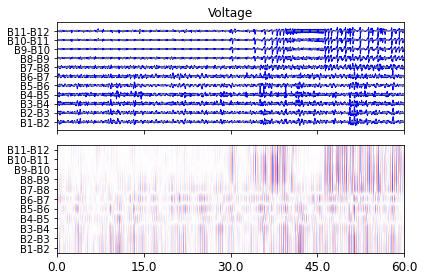

In [83]:
offset = 10

fig, (ax1, ax2) = subplots(nrows=2, figsize=(6,4))

### Voltage Series
ax1.plot(data_chan_seg_norm + offset*arange(chans-1,-1,-1), linewidth=1, color='b');
ax1.plot(zeros((rows_seg, chans)) + offset*arange(chans-1,-1,-1),'--',color='gray');
ax1.set_yticks(offset*arange(chans))
ax1.set_yticklabels(elec_label_names)
ax1.margins(x=0)
ax1.set_xticks(linspace(0, rows_seg, 5))
labl =        linspace((sample_start+seg_start)//sr, (sample_start+seg_stop)//sr, 5)
ax1.set_xticklabels([], fontsize=12)
ax1.set_title('Voltage', fontsize=12)


### Voltage Heatmap
ax2.imshow(data_chan_seg_norm.T, aspect='auto', cmap='bwr', vmin=-3, vmax=3);
ax2.set_yticks(arange(chans))
ax2.set_yticklabels(flip(elec_label_names));

ax2.set_xticks(linspace(0, rows_seg, 5))
labl =        linspace((sample_start+seg_start)//sr, (sample_start+seg_stop)//sr, 5)
ax2.set_xticklabels(labl, fontsize=12)

fig.tight_layout()

show()


# Plot boxplots of all channels in electrode 'B'

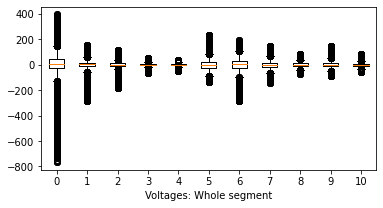

Channel with index 0, B1-B2, has the largest spread.


In [85]:
fig, ax = subplots(figsize=(6, 3))

ax.boxplot(data_chan_seg);
ax.set_xlabel('Voltages: Whole segment')
ax.set_xticklabels(arange(chans));

show()
print('Channel with index 0, B1-B2, has the largest spread.')

# Plot histograms of all channels in electrode 'T'

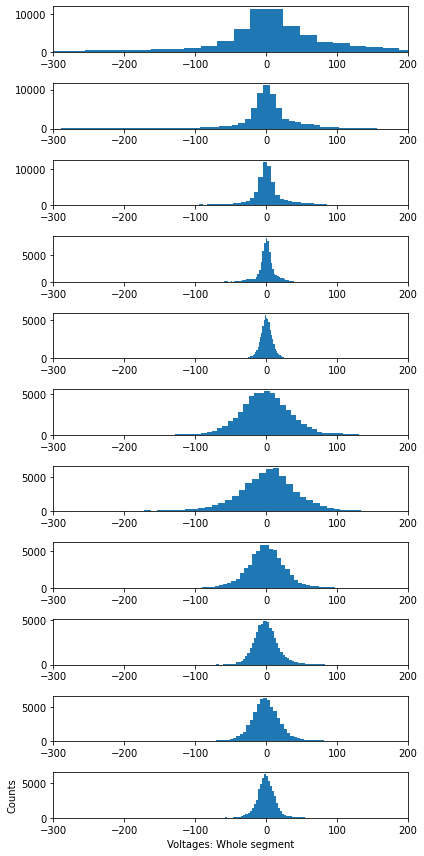

In [92]:
fig, ax = subplots(nrows=chans, figsize=(6,12))

bins = 50

for index in arange(chans):
    
    ax[index].hist(data_chan_seg[:,index], bins=bins);
    ax[index].set_xlim(-300, 200)
    
ax[-1].set_xlabel('Voltages: Whole segment')
ax[-1].set_ylabel('Counts');

fig.tight_layout()

show()



# Which channels have the largest count per bin?

Channel with index 0.

# What is unusual about the histogram of channel with index 1?



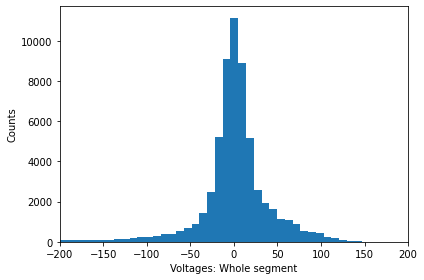

In [94]:
fig, ax = subplots(figsize=(6,4))

bins = 50
    
special_index = 1

ax.hist(data_chan_seg[:, special_index], bins=bins);
ax.set_xlim(-200, 200)
    
ax.set_xlabel('Voltages: Whole segment')
ax.set_ylabel('Counts');

fig.tight_layout()

show()

This histogram has the second largest spread of all channels on 'B'.


# Plot Fourier spectra of channels with indices 0 and 7

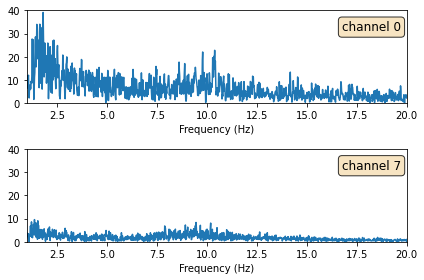

In [100]:
chan1, chan2 =0, 7

xlim, ylim = 20, 40

# frequencies
freqs = rfftfreq((seg_stop-seg_start), 1 / sr)

# amplitude
amplitudes = (2.0 / rows_max)*abs(rfft(data_chan_seg, axis=0))


fig, ax = subplots(nrows=2, figsize=(6, 4))

ax[0].plot(freqs, amplitudes[:, chan1]);
ax[0].set_xlim(1, xlim);
ax[0].set_ylim(0, ylim);
ax[0].set_xlabel('Frequency (Hz)');

ax[1].plot(freqs, amplitudes[:, chan2]);
ax[1].set_xlim(1, xlim);
ax[1].set_ylim(0, ylim);
ax[1].set_xlabel('Frequency (Hz)');

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)

# place a text box in upper left in axes coords
textstr = 'channel ' + str(chan1)

ax[0].text(0.83, 0.89, textstr, transform=ax[0].transAxes, fontsize=12,
    verticalalignment='top', bbox=props)

textstr = 'channel ' + str(chan2)

ax[1].text(0.83, 0.89, textstr, transform=ax[1].transAxes, fontsize=12,
    verticalalignment='top', bbox=props)

fig.tight_layout()

show()


# What is the dominant frequency of channel with index 0?

The dominant frequency of channel is about 1.2 Hz.


# What is the main difference in the dominant frequency of channel with index 0 in the first and second half of the segment?

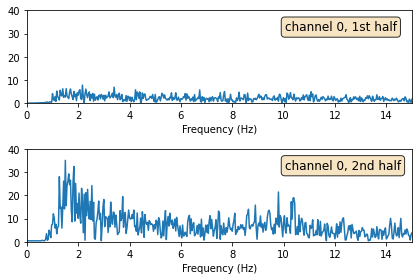

In [103]:
chan = 0

xlim, ylim = 15, 40

# frequencies
freqs = rfftfreq(rows_seg//2, 1 / sr)

# amplitude
amplitudes_1 = (2.0 / rows_max)*abs(rfft(data_chan_seg[:rows_seg//2, :], axis=0))
amplitudes_2 = (2.0 / rows_max)*abs(rfft(data_chan_seg[rows_seg//2:, :], axis=0))


fig, ax = subplots(nrows=2, figsize=(6, 4))

ax[0].plot(freqs, amplitudes_1[:, chan]);
ax[0].set_xlim(0, xlim);
ax[0].set_ylim(0, ylim);
ax[0].set_xlabel('Frequency (Hz)');

ax[1].plot(freqs, amplitudes_2[:, chan]);
ax[1].set_xlim(0, xlim);
ax[1].set_ylim(0, ylim);
ax[1].set_xlabel('Frequency (Hz)');

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)

# place a text box in upper left in axes coords
textstr = 'channel ' + str(chan) + ', 1st half'

ax[0].text(0.67, 0.89, textstr, transform=ax[0].transAxes, fontsize=12,
    verticalalignment='top', bbox=props)

textstr = 'channel ' + str(chan) + ', 2nd half'

ax[1].text(0.67, 0.89, textstr, transform=ax[1].transAxes, fontsize=12,
    verticalalignment='top', bbox=props)

fig.tight_layout()

show()


The dominant frequency of oscillations in the first half of the segment is about 2.2 Hz.

The dominant frequency of oscillations in the second half of the segment is about 1.6 Hz.

# Calculate and plot the (absolute) correlation matrix of electrode 'B'


In [104]:
data_chan_seg_corr = corrcoef(data_chan_seg, rowvar=False)

fill_diagonal(data_chan_seg_corr, 0)

data_chan_seg_corr_abs      = abs(data_chan_seg_corr)


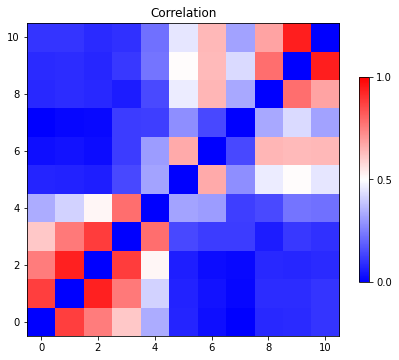

In [107]:
fig, ax = subplots(figsize=(6, 6))

# Voltage matrices
im = ax.imshow(data_chan_seg_corr_abs, cmap='bwr', origin='lower', vmax=1);
fig.colorbar(im, ax=ax, ticks=(0, 0.5, 1), shrink = 0.5);
ax.set_title('Correlation')

fig.tight_layout()

show()


# Which two blocks of channels can you find in this matrix?

channel 0-5 and channel 6-11

# Which channel has the strongest (absolute) overall correlation?

array([9], dtype=int64)

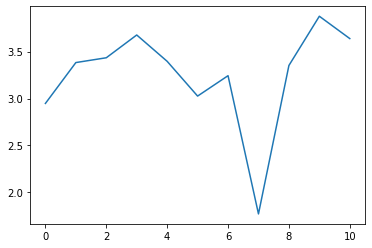

In [108]:
fig, ax = subplots()

ax.plot(sum(data_chan_seg_corr_abs))
where(sum(data_chan_seg_corr_abs) == max(sum(data_chan_seg_corr_abs)))[0]


# Threshold the correlation matrix of electrode 'B' at 0.5 and set all values below this threshold to zero

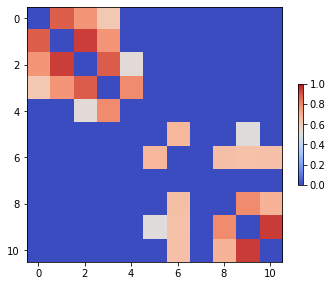

In [109]:
threshold = 0.5

data_chan_seg_corr_abs[abs(data_chan_seg_corr_abs) <= threshold] = 0

fig, ax = subplots(nrows=1, figsize = (5, 5))

im1 = ax.imshow(abs(data_chan_seg_corr_abs), cmap='coolwarm', vmin=0, vmax=1);

fig.colorbar(im1, ax=ax, orientation='vertical', shrink=0.3);

fig.tight_layout()


# Construct a network of all channels on electrode 'B' under the threshold 0.5

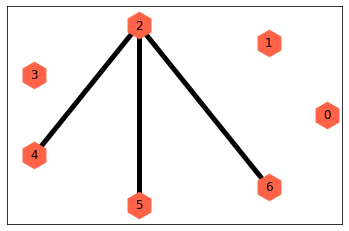

In [56]:
graph_1 = nx.Graph(data_chan_seg_corr_abs)

layout = nx.circular_layout(graph_1)

nx.draw_networkx(graph_1, layout,
        with_labels=True, 
        node_color='tomato', 
        node_size=700, width=5,
        node_shape='h')


# Under the threshold 0.5, which channel is not connected on electrode 'B'?

0,1,3